In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sscCdi

In [21]:
def create_image_from_text(text):
    from matplotlib.backends.backend_agg import FigureCanvas
    fig = plt.Figure(figsize=(2.56, 2.56), dpi=200)
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    t = ax.text(0.5, 0.5, text, fontsize=30, fontweight='heavy', ha='center', va='center')
    ax.axis('off')
    canvas.draw()
    img = 1- np.array(canvas.renderer.buffer_rgba())[:, :, 0]/255
    return img

import numpy as np
import matplotlib.pyplot as plt

def propagator_fresnel(wavefront, wavelength, pixel_size, sample_to_detector_distance, source_to_sample_distance = 0,detector_pixel_size=0, method='ASM_TF'):
    
    K = 2*np.pi/wavelength # wavenumber
    z2 = sample_to_detector_distance
    z1 = source_to_sample_distance # NOT USED
    if  detector_pixel_size == 0: detector_pixel_size = pixel_size

    evaluate_sampling(wavefront,wavelength,pixel_size,sample_to_detector_distance)

    FT = np.fft.fftshift(np.fft.fft2(wavefront))
    if method == "ASM_TF": # Transfer Function for the Angular Spectrum Method
        FX, FY = get_frequency_grid(wavefront,pixel_size)
        transfer_function = np.exp(1j*2*np.pi*z2*np.sqrt(wavelength**-2 - FX**2 - FY**2)) # transfer function of free-space
        propagated_wave = np.fft.ifft2(np.fft.ifftshift(FT * transfer_function))*np.exp(1j*K*z2) 
    elif method == "fresnel_TF": # Transfer Function using Fresnel Approximation (paraxial)
        FX, FY = get_frequency_grid(wavefront,pixel_size)
        transfer_function = np.exp(1j*2*np.pi*z2*(wavelength**-1 - wavelength*FX**2/2 - wavelength*FY**2/2))
        propagated_wave = np.fft.ifft2(np.fft.ifftshift(FT * transfer_function))*np.exp(1j*K*z2)    
    elif method == 'fresnel_IR': # Impulse Response using Fresnel approximation (paraxial)
        y, x = np.indices(wavefront.shape)
        X, Y =  (x - x.shape[1]//2)*pixel_size, (y - y.shape[0]//2)*pixel_size
        impulse_response = np.exp(1j*K*z2)/(1j*wavelength*z2)*np.exp(1j*K*(X**2+Y**2)/(2*z2))
        propagated_wave = np.fft.ifftshift(np.fft.ifft2(FT * np.fft.fftshift(np.fft.fft2(impulse_response))))
    elif method == 'fresnel_2step_magnification':
        evaluate_sampling_2step(wavefront,wavelength,pixel_size,sample_to_detector_distance,detector_pixel_size)
        M = pixel_size/detector_pixel_size
        y, x = np.indices(wavefront.shape)
        sampleX, sampleY =  (x - x.shape[1]//2)*pixel_size, (y - y.shape[0]//2)*pixel_size
        detectorX, detectorY =  (x - x.shape[1]//2)*detector_pixel_size, (y - y.shape[0]//2)*detector_pixel_size
        FX, FY = get_frequency_grid(wavefront,pixel_size)
        factor1 = M*np.exp(1j*K*z2)*np.exp(-1j*K/(2*z2)*(1/M-1)*(detectorX**2+detectorY**2))
        factor2 = np.exp(-1j*np.pi*wavelength*z2*(1/M)*(FX**2+FY**2))
        factor3 = wavefront*np.exp(1j*K/(2*z2)*(1-M)*(sampleX**2+sampleY**2))
        propagated_wave = factor1*np.fft.ifft2(factor2*np.fft.fftshift(np.fft.fft2(factor3)))
    else:
        raise ValueError("Select a proper propagation method")

    return propagated_wave

def propagator_FST(wavefront, wavelength, pixel_size, sample_to_detector_distance, source_to_sample_distance = 0):

    """ Propagator using Fresnel Scaling Theorem """

    np = cp.get_array_module(wavefront) # make code agnostic to cupy and numpy
    
    K = 2*np.pi/wavelength # wavenumber
    z2 = sample_to_detector_distance
    z1 = source_to_sample_distance
    
    if z1 != 0:
        M = 1 + (z2/z1)
    else:
        M = 1
    
    FT = np.fft.fftshift(np.fft.fft2(wavefront))

    FX, FY = get_frequency_grid(wavefront,pixel_size/M)

    # kernel = np.exp(-1j*(z2/M)/(2*K)*(FX**2+FY**2)) # if using angular frequencies. Formula as in Paganin equation 1.28
    kernel = np.exp(-1j*np.pi*wavelength*(z2/M)*(FX**2+FY**2)) # if using standard frequencies. Formula as in Goodman, Fourier Optics, equation 4.21

    wave_parallel = np.fft.ifft2(np.fft.ifftshift(FT * kernel))*np.exp(1j*K*z2/M)

    if z1 != 0:
        # gamma_M = 1 - 1/M
        # y, x = np.indices(wavefront.shape)
        # y = (y - y.shape[0]//2)*pixel_size/M
        # x = (x - x.shape[1]//2)*pixel_size/M
        wave_cone = wave_parallel * (1/M) #* np.exp(1j*gamma_M*K*z2) * np.exp(1j*gamma_M*K*(x**2+y**2)/(2*z2)) # Need to check the commented phase terms, which are part of the full form for the Fresnel Scaling theorem (i.e. without calculating absolute value)
        return wave_cone
    else:
        return wave_parallel

def get_frequency_grid(data,pixel_size):
    ny, nx = data.shape
    fx = np.fft.fftshift(np.fft.fftfreq(nx,d = pixel_size))#*2*np.pi 2*np.pi factor to calculate angular frequencies 
    fy = np.fft.fftshift(np.fft.fftfreq(ny,d = pixel_size))#*2*np.pi
    FX, FY = np.meshgrid(fx,fy)
    return FX, FY

def evaluate_sampling(wavefront,wavelength,pixel_size,sample_to_detector_distance):
    lateral_size = max(wavefront.shape)*pixel_size
    sampling = wavelength*sample_to_detector_distance/pixel_size/(lateral_size)
    if sampling > 1:
        print("IR preferred",sampling)
    elif sampling < 1: 
        print("TF preferred",sampling)
    elif sampling == 1:
        print("Egal. Critical sampling",sampling)

def evaluate_sampling_2step(wavefront,wavelength,pixel_size,sample_to_detector_distance,detector_pixel_size):

    N = wavefront.shape[0] # assumes shape to be the same in X and Y
    criteriaB10 = wavelength*sample_to_detector_distance/np.abs(N*pixel_size-N*detector_pixel_size) # see Appendix B of Voelz - Computational Fourier Optics, equations B10 to B12
    criteriaB11 = pixel_size/detector_pixel_size * criteriaB10
    criteriaB12 = wavelength*sample_to_detector_distance/(N*detector_pixel_size)

    print(f"{criteriaB12} < Pxl = {pixel_size} < {min(criteriaB10,criteriaB11)}  -> Is this true?")


def diffraction_square_apperture(x,y,distance,wavelength, half_width):
    fresnel_number = half_width**2/(distance*wavelength)
    a1 = -np.sqrt(2)*(np.sqrt(fresnel_number)+x/np.sqrt(distance*wavelength))
    a2 = np.sqrt(2)*(np.sqrt(fresnel_number)-x/np.sqrt(distance*wavelength))
    b1 = -np.sqrt(2)*(np.sqrt(fresnel_number)+y/np.sqrt(distance*wavelength))
    b2 = np.sqrt(2)*(np.sqrt(fresnel_number)-y/np.sqrt(distance*wavelength))

    Sa1,Ca1 = scipy.special.fresnel(a1)
    Sa2,Ca2 = scipy.special.fresnel(a2)
    Sb1,Cb1 = scipy.special.fresnel(b1)
    Sb2,Cb2 = scipy.special.fresnel(b2)

    return np.exp(1j*2*np.pi/wavelength*distance)/(2*1j)*((Ca2-Ca1)+1j*(Sa2-Sa1))*((Cb2-Cb1)+1j*(Sb2-Sb1)) # equation 4.46, Goodman, Introduction to Fourier Optics

def create_square_apertude(N,pixel,half_width):
    Y, X = np.indices((N,N))
    Y = (Y - N//2)*pixel
    X = (X - N//2)*pixel
    aperture = np.where( np.abs(X) > half_width, 0, np.where(np.abs(Y) > half_width,0,1))
    return aperture, X, Y

# wavelength = sscCdi.wavelength_from_energy(22)
wavelength = 1e-10/2
pixel_size = 1e-6
source_to_sample_distance = 1e-3
sample_to_detector_distance = 10 #- source_to_sample_distance  
half_width = 100e-6

# wavelength = sscCdi.wavelength_from_energy(22)
pixel_size = 1.44e-6
source_to_sample_distance = 5e-3
sample_to_detector_distance = 1 - source_to_sample_distance  
half_width = 100e-6

wavefront,X,Y = create_square_apertude(500,pixel_size,half_width)
wavefront = wavefront*np.exp(1j*wavefront)

analytical = diffraction_square_apperture(X,Y,sample_to_detector_distance,wavelength, half_width)

# fig, ax = plt.subplots(2,2,dpi=150)
# ax[0,0].imshow(np.abs(wavefront))
# ax[0,1].imshow(np.angle(wavefront))
# ax[1,0].imshow(np.abs(propagated_wavefront))
# ax[1,1].imshow(np.angle(propagated_wavefront))


TF preferred 0.04798418209876544
TF preferred 0.04798418209876544
TF preferred 0.04798418209876544


Text(0.5, 1.0, 'Analytic')

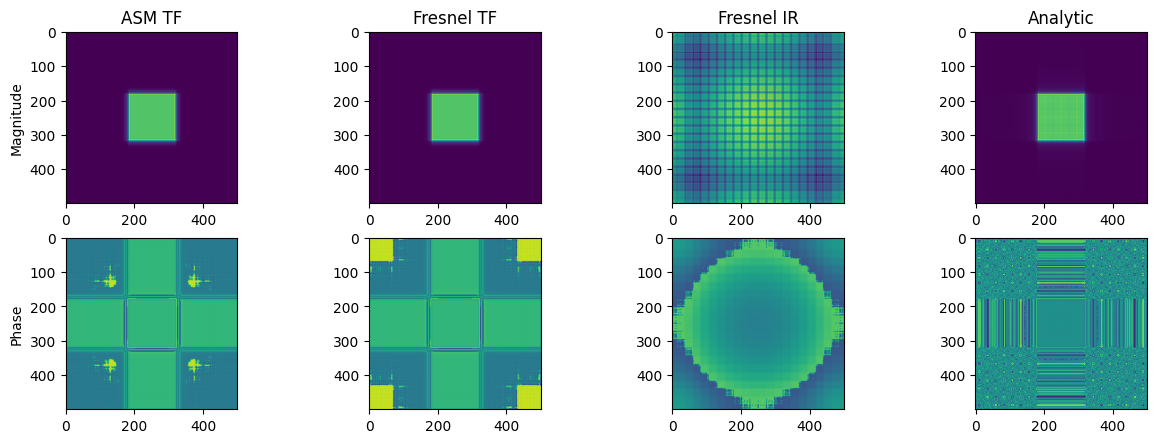

In [23]:
ASM_TF = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,method='ASM_TF')
fresnel_TF = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,method='fresnel_TF')
fresnel_IR = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,method='fresnel_IR')

fig, ax = plt.subplots(2,4,dpi=100,figsize=(15,5))
ax[0,0].set_ylabel('Magnitude')
ax[1,0].set_ylabel('Phase')
ax[0,0].imshow(np.abs(ASM_TF))
ax[1,0].imshow(np.angle(ASM_TF))
ax[0,0].set_title('ASM TF')
ax[0,1].imshow(np.abs(fresnel_TF))
ax[1,1].imshow(np.angle(fresnel_TF))
ax[0,1].set_title('Fresnel TF')
ax[0,2].imshow(np.abs(fresnel_IR))
ax[1,2].imshow(np.angle(fresnel_IR))
ax[0,2].set_title('Fresnel IR')
ax[0,3].imshow(np.abs(analytical))
ax[1,3].imshow(np.angle(analytical))
ax[0,3].set_title('Analytic')

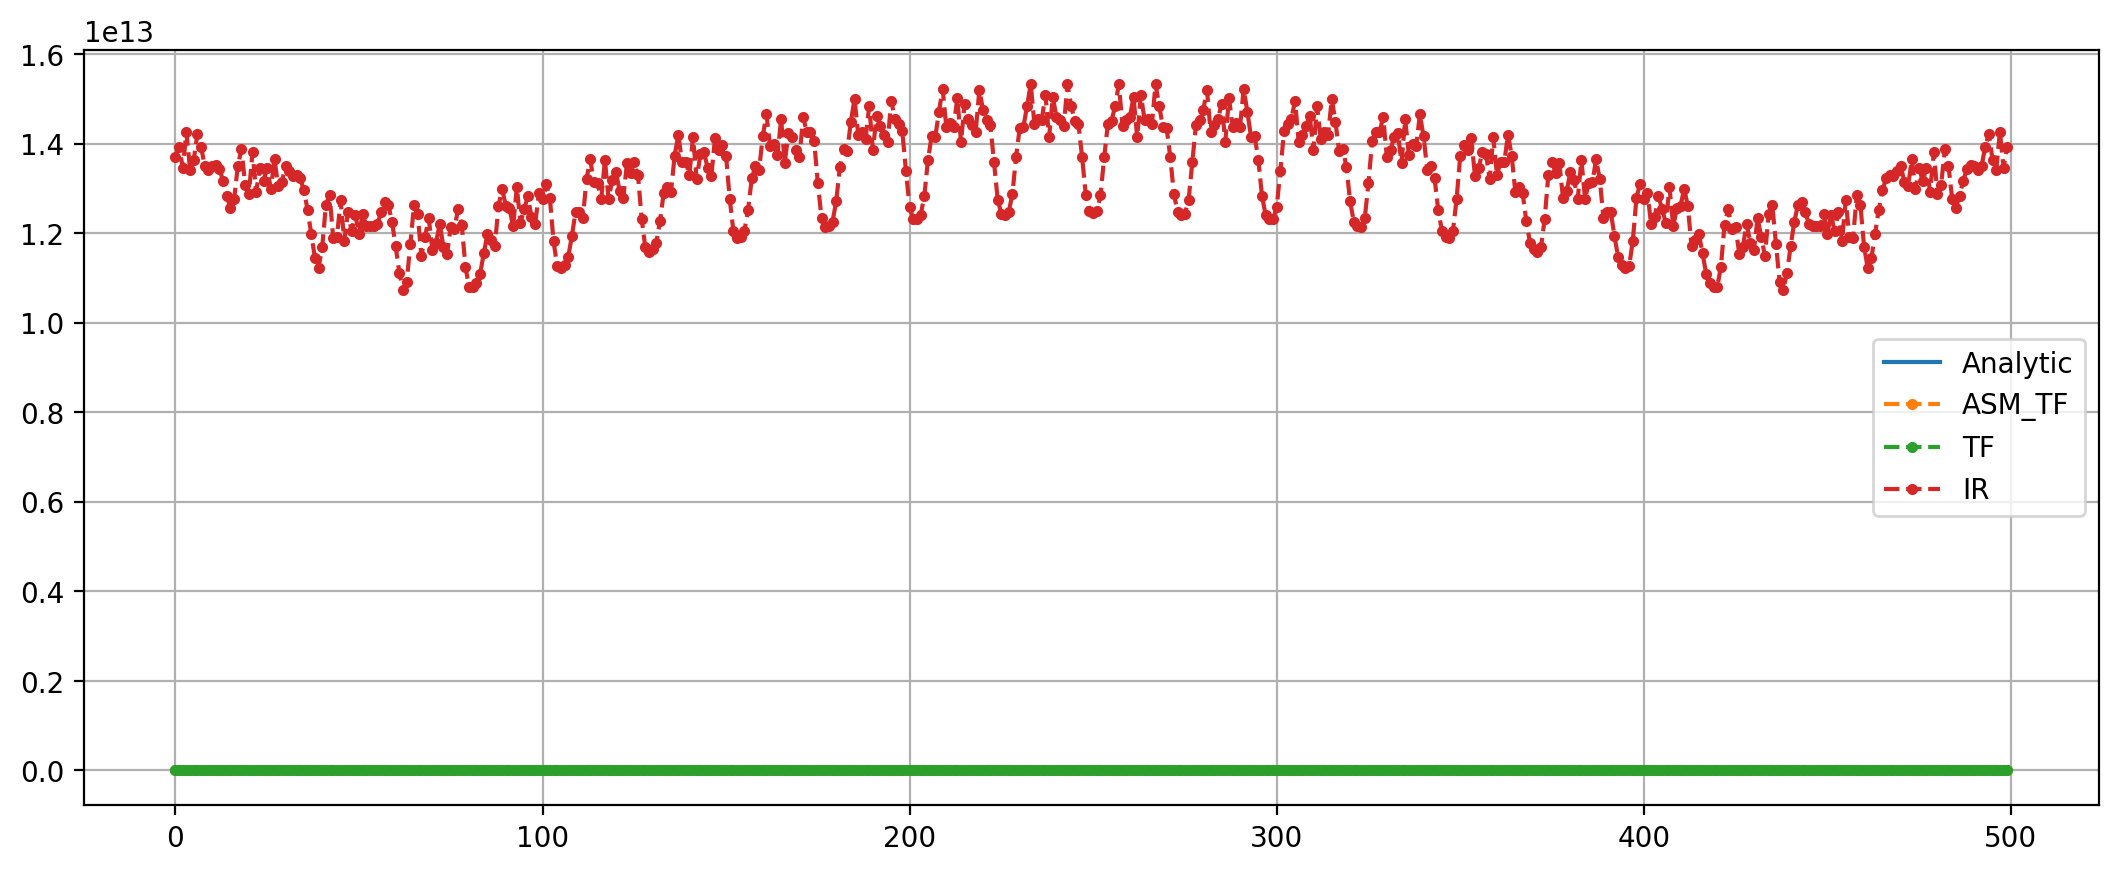

In [24]:

fig, ax = plt.subplots(figsize=(13,5),dpi=200)
ax.plot(np.abs(analytical)[analytical.shape[0]//2,:],label='Analytic')
ax.plot(np.abs(ASM_TF)[ASM_TF.shape[0]//2,:],'--.',label='ASM_TF')
ax.plot(np.abs(fresnel_TF)[fresnel_TF.shape[0]//2,:],'--.',label='TF')
ax.plot(np.abs(fresnel_IR)[fresnel_IR.shape[0]//2,:],'--.',label='IR')
ax.grid()
ax.legend()